## RandomForest_XGboost_with_V2_F1
Trying out the alternative feature engineering from Linear regression and going for a second version.

Experiment: What changes if we use time-series based evaluation (test-split) rather than regular? 

#### Second Exploration
Try try using the exact same RandomForest modelling and optimizing as before and see how it performs!

In [1]:
#initial imports 
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get the absolute path of the current file/notebook
# If using Jupyter, use Path.cwd(). If using a .py script, use Path(__file__).parent
curr_dir = Path.cwd()

# Calculate the project root (adjust '.parent' count as needed)
# If your notebook is in 'project/notebooks/', the root is 1 level up
project_root = curr_dir.parent.parent 

# Add project root to system path so Python can find 'utils'
sys.path.append(str(project_root))

print(f"Project Root added to path: {project_root}")

from utils.feature_engineer_df import build_features 

#for the scaling and encoding 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_curve
)
#cleanup
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Project Root added to path: /Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters


V2 Imports

In [2]:
# Get the project root
curr_dir = Path.cwd()
project_root = curr_dir.parent.parent
sys.path.append(str(project_root))

# Load cleaned data
cleaned_path = project_root / "data" / "cleaned" / "kickstarter_cleaned.csv"

# Load cleaned data
df = pd.read_csv(cleaned_path, encoding='latin-1', low_memory=False)
print(f"Loaded cleaned dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Convert launched to datetime
df['launched'] = pd.to_datetime(df['launched'], errors='coerce')
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')

# Filter only on launch-time valid fields (NOT pledged/backers)
df = df[df['usd_goal_real'] > 0].copy()
df = df[df['launched'].notna()].copy()
df = df[df['deadline'].notna()].copy()

print(f"\nAfter filtering (goal > 0, valid dates): {df.shape[0]:,} rows")
print("Target distribution:")
print(df['target'].value_counts())
print(f"Success rate: {df['target'].mean():.2%}")


Loaded cleaned dataset: 331,675 rows × 10 columns

After filtering (goal > 0, valid dates): 331,675 rows
Target distribution:
target
0    197719
1    133956
Name: count, dtype: int64
Success rate: 40.39%


In [3]:
df.head()

,id,main_category,deadline,launched,backers,country,usd_pledged_real,usd_goal_real,duration_days,target
0,1000002330,Publishing,2015-10-09,2015-08-11 12:12:28,0,GB,0.0,1533.95,58,0
1,1000003930,Film & Video,2017-11-01,2017-09-02 04:43:57,15,US,2421.0,30000.00,59,0
2,1000004038,Film & Video,2013-02-26,2013-01-12 00:20:50,3,US,220.0,45000.00,44,0
3,1000007540,Music,2012-04-16,2012-03-17 03:24:11,1,US,1.0,5000.00,29,0
4,1000014025,Food,2016-04-01,2016-02-26 13:38:27,224,US,52375.0,50000.00,34,1


### Feature Engineering (Recreate from 02_feature_engineering.ipynb)

We'll recreate the same preprocessing steps to ensure consistency.

In [4]:
# Step 1: Create basic categorical features BEFORE time split
# These don't depend on aggregates, so it is safe to create before splitting

# Create main_category_grouped
category_map = {
    'Art': 'Creative', 'Comics': 'Creative', 'Crafts': 'Creative',
    'Dance': 'Creative', 'Design': 'Creative',
    'Fashion': 'Consumer', 'Food': 'Consumer',
    'Film & Video': 'Entertainment', 'Games': 'Entertainment',
    'Music': 'Entertainment', 'Theater': 'Entertainment',
    'Photography': 'Creative', 'Publishing': 'Creative',
    'Technology': 'Tech', 'Journalism': 'Other'
}
df['main_category_grouped'] = df['main_category'].map(category_map).fillna('Other')

# Create continent
continent_map = {
    'US': 'North America', 'CA': 'North America', 'MX': 'North America',
    'GB': 'Europe', 'DE': 'Europe', 'FR': 'Europe', 'IT': 'Europe',
    'ES': 'Europe', 'NL': 'Europe', 'IE': 'Europe', 'SE': 'Europe',
    'CH': 'Europe', 'AT': 'Europe', 'DK': 'Europe', 'BE': 'Europe',
    'LU': 'Europe', 'NO': 'Europe',
    'AU': 'Oceania', 'NZ': 'Oceania',
    'JP': 'Asia', 'SG': 'Asia', 'HK': 'Asia'
}
df['continent'] = df['country'].map(continent_map).fillna('Other')

# Create month features (from launch/deadline dates)
df['launched_month'] = df['launched'].dt.month
df['deadline_month'] = df['deadline'].dt.month

# Add weekday feature
df['launched_weekday'] = df['launched'].dt.weekday

print("Created basic categorical features:")
print(f"  - main_category_grouped: {df['main_category_grouped'].nunique()} categories")
print(f"  - continent: {df['continent'].nunique()} categories")
print(f"  - launched_month: {df['launched_month'].nunique()} months (1-12)")
print(f"  - launched_weekday: {df['launched_weekday'].nunique()} weekdays (0=Monday, 6=Sunday)")

# Step 2: Time based split
# Sort by launch date
df_sorted = df.sort_values('launched').copy()

# Use 70% earliest projects for training, 30% latest for testing
split_idx = int(len(df_sorted) * 0.7)
df_train_raw = df_sorted.iloc[:split_idx].copy()
df_test_raw = df_sorted.iloc[split_idx:].copy()

print("\nTime-based split:")
print(f"Train: {df_train_raw['launched'].min()} to {df_train_raw['launched'].max()}")
print(f"Test:  {df_test_raw['launched'].min()} to {df_test_raw['launched'].max()}")
print(f"\nTrain size: {len(df_train_raw):,} ({len(df_train_raw)/len(df_sorted):.1%})")
print(f"Test size:  {len(df_test_raw):,} ({len(df_test_raw)/len(df_sorted):.1%})")
print(f"\nTrain success rate: {df_train_raw['target'].mean():.2%}")
print(f"Test success rate:  {df_test_raw['target'].mean():.2%}")


Created basic categorical features:
  - main_category_grouped: 5 categories
  - continent: 4 categories
  - launched_month: 12 months (1-12)
  - launched_weekday: 7 weekdays (0=Monday, 6=Sunday)

Time-based split:
Train: 2009-04-21 21:02:48 to 2015-11-10 01:13:52
Test:  2015-11-10 01:15:38 to 2017-12-29 03:22:32

Train size: 232,172 (70.0%)
Test size:  99,503 (30.0%)

Train success rate: 40.74%
Test success rate:  39.56%


In [5]:
# Step 4: Prepare features
# usd_goal_real spans 8 orders of magnitude - log transform is really important
df_train_raw['log_usd_goal'] = np.log1p(df_train_raw['usd_goal_real'])
df_test_raw['log_usd_goal'] = np.log1p(df_test_raw['usd_goal_real'])

# Add goal_per_day feature (intensity: goal per day)
# "I need CHF 50k in 10 days" is different from "in 60 days"
df_train_raw['goal_per_day'] = df_train_raw['log_usd_goal'] / (df_train_raw['duration_days'] + 1)
df_test_raw['goal_per_day'] = df_test_raw['log_usd_goal'] / (df_test_raw['duration_days'] + 1)

# Columns to drop (keep 'launched' temporarily for train/val split)
columns_to_drop = [
    'id', 'main_category', 'deadline',
    'backers', 'usd_pledged_real', 'usd_pledged_bins', 'backers_per_pledged', 
    'backer_pledged_bins', 'pledged_per_category',
    'launched_year', 'deadline_year', 'usd_goal_real',
    'usd_goal_bins', 'category_goal_percentile', 'duration_bins',
    'country',
    'deadline_month',
]

# Prepare feature sets
df_train_clean = df_train_raw.drop(columns=[col for col in columns_to_drop if col in df_train_raw.columns])
df_test_clean = df_test_raw.drop(columns=[col for col in columns_to_drop if col in df_test_raw.columns])

print("Features after cleaning:")
print(f"Train: {df_train_clean.shape[1]} columns")
print(f"Test:  {df_test_clean.shape[1]} columns")
print(f"\nFeature columns: {[c for c in df_train_clean.columns if c != 'target']}")


Features after cleaning:
Train: 9 columns
Test:  9 columns

Feature columns: ['launched', 'duration_days', 'main_category_grouped', 'continent', 'launched_month', 'launched_weekday', 'log_usd_goal', 'goal_per_day']


In [6]:
# Step 5: Split train into train/val for threshold optimization
# This prevents overfitting threshold choice to training data
df_train_clean_sorted = df_train_clean.sort_values('launched').copy()
val_split_idx = int(len(df_train_clean_sorted) * 0.8)  # 80% train, 20% val

df_train_final = df_train_clean_sorted.iloc[:val_split_idx].copy()
df_val_final = df_train_clean_sorted.iloc[val_split_idx:].copy()

print("Train/Val split (time-based):")
print(f"Train: {df_train_final['launched'].min()} to {df_train_final['launched'].max()}")
print(f"Val:    {df_val_final['launched'].min()} to {df_val_final['launched'].max()}")
print(f"\nTrain size: {len(df_train_final):,} ({len(df_train_final)/len(df_train_clean_sorted):.1%})")
print(f"Val size:   {len(df_val_final):,} ({len(df_val_final)/len(df_train_clean_sorted):.1%})")
print(f"Test size:  {len(df_test_clean):,}")

# Now drop 'launched' and separate X and y
X_train = df_train_final.drop(columns=['target', 'launched'])
y_train = df_train_final['target']
X_val = df_val_final.drop(columns=['target', 'launched'])
y_val = df_val_final['target']
X_test = df_test_clean.drop(columns=['target', 'launched'])
y_test = df_test_clean['target']

print("\nFinal feature matrices:")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")
print("\nTarget distributions:")
print(f"Train: {y_train.value_counts().to_dict()}")
print(f"Val:   {y_val.value_counts().to_dict()}")
print(f"Test:  {y_test.value_counts().to_dict()}")

Train/Val split (time-based):
Train: 2009-04-21 21:02:48 to 2015-02-28 15:46:13
Val:    2015-02-28 15:53:08 to 2015-11-10 01:13:52

Train size: 185,737 (80.0%)
Val size:   46,435 (20.0%)
Test size:  99,503

Final feature matrices:
X_train: (185737, 7)
X_val:   (46435, 7)
X_test:  (99503, 7)

Target distributions:
Train: {0: 106443, 1: 79294}
Val:   {0: 31141, 1: 15294}
Test:  {0: 60135, 1: 39368}


In [7]:
df_train_clean_sorted.columns

Index(['launched', 'duration_days', 'target', 'main_category_grouped',
       'continent', 'launched_month', 'launched_weekday', 'log_usd_goal',
       'goal_per_day'],
      dtype='object')

In [8]:
# Step 6: Create preprocessing pipeline using ColumnTransformer

# Identify feature types
numeric_features = ['log_usd_goal', 'duration_days', 'goal_per_day', 'launched_weekday']
categorical_features = ['launched_month', 'main_category_grouped', 'continent']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # Drop any other columns
)

# Fit on training data and transform all sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
numeric_names = numeric_features
cat_encoder = preprocessor.named_transformers_['cat']
cat_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = list(numeric_names) + list(cat_names)

# Convert to DataFrames for easier inspection
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_val_final = pd.DataFrame(X_val_processed, columns=feature_names, index=X_val.index)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("After preprocessing:")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_val_final:   {X_val_final.shape}")
print(f"X_test_final:  {X_test_final.shape}")
print(f"\nFeature names: {feature_names}")

After preprocessing:
X_train_final: (185737, 21)
X_val_final:   (46435, 21)
X_test_final:  (99503, 21)

Feature names: ['log_usd_goal', 'duration_days', 'goal_per_day', 'launched_weekday', 'launched_month_2', 'launched_month_3', 'launched_month_4', 'launched_month_5', 'launched_month_6', 'launched_month_7', 'launched_month_8', 'launched_month_9', 'launched_month_10', 'launched_month_11', 'launched_month_12', 'main_category_grouped_Creative', 'main_category_grouped_Entertainment', 'main_category_grouped_Other', 'main_category_grouped_Tech', 'continent_North America', 'continent_Oceania']


## Prepare for Machine Learning

Different steps than before - all done above 

### Get a baseline first

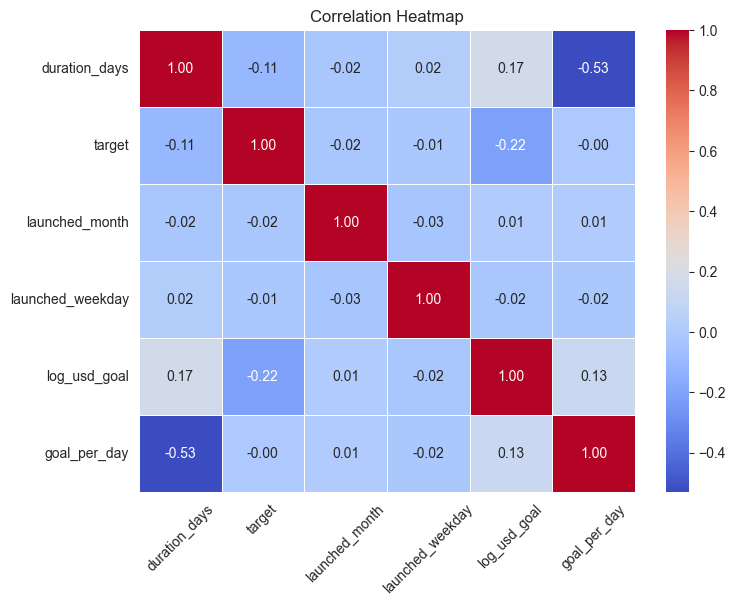

In [9]:
matrix = df_train_final.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
#works out of the box 
plt.tick_params(axis='x', labelrotation=45)
#add tick rotation if needed
plt.show()

## Random Forest 
using the train-test-split: 
* X_train_final
* X_val_final
* X_test_final
* y_train
* y_val  
* y_test

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

In [11]:
#get features for feature importance 
features = list(X_train_final.columns)
#create a model
model = RandomForestClassifier(n_estimators = 50, #start low
                               random_state = 42, #just any
                               max_features=8, #manually set it to 1/2 dataset 
                               n_jobs=-1, #use whole CPU
                               )
#fit the model
model.fit(X_train_final, y_train)

RandomForestClassifier(max_features=8, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [12]:
#first description of the model 
n_nodes = []
max_depths = []
#create stats 
for tree in model.estimators_:
  n_nodes.append(tree.tree_.node_count) #ask the tree how many nodes it has
  max_depths.append(tree.tree_.max_depth)
#get averages  
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 91453
Average maximum depth 45


In [13]:
#check the original
train_predictions = model.predict(X_train_final)
train_probabilites = model.predict_proba(X_train_final)[:, 1] #get the positives
#check with test: 
test_predictions = model.predict(X_test_final)
test_probabilities = model.predict_proba(X_test_final)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probabilites)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probabilities)}')
print(f"Baseline ROC AUC calling everyone successful: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}")

Train ROC AUC Score: 0.951637809016733
Test ROC AUC Score: 0.6328087944761285
Baseline ROC AUC calling everyone successful: 0.5


#### Original scores V1: 
* Train ROC AUC Score: 0.9344639720579019
* Test ROC AUC Score: 0.6197402656005501
* Baseline ROC AUC calling everyone successful: 0.5

In [14]:
matrix = confusion_matrix(y_test, test_predictions)
print(matrix)

[[44077 16058]
 [22271 17097]]


In [15]:
fi_model = pd.DataFrame({'feature': features,
                         'importance': model.feature_importances_}).sort_values('importance', ascending=False)
fi_model.head()

,feature,importance
0,log_usd_goal,0.250083
2,goal_per_day,0.231835
3,launched_weekday,0.171916
1,duration_days,0.098060
16,main_category_grouped_Entertainment,0.023361


### one shot at optimization

In [16]:
#hyperparameter grid 
param_grid = {
    'n_estimators': [10, 20, 40, 50, 70, 90, 120], #just because I can, fibonacci-style guess
    'max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'max_features': ['auto', 'sqrt', None, 8], 
    'max_leaf_nodes': [20, 100, 1000, 3000, 8000, 20000, 60000, 100000],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

#get an instance to use for random search:
estimator = RandomForestClassifier(random_state = 42)
#create random search model 
rs = RandomizedSearchCV(estimator,
                        param_grid, 
                        n_jobs = -1,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_iter = 10,
                        verbose = 4, 
                        random_state = 42)

# fit it 
rs.fit(X_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_fea

[CV 4/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.456 total time=  10.6s
[CV 5/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.570 total time=  10.7s
[CV 3/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.648 total time=  10.9s
[CV 1/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.625 total time=  10.9s
[CV 2/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.650 total time=  11.3s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.668 total time=  10.6s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nod

/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.650 total time=   1.5s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.666 total time=   1.7s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.664 total time=   1.5s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.511 total time=   1.7s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.573 total time=   1.5s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.606 total time=  10.8s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.520 total time=  11.4s
[CV 1/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.654 total time=  33.3s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_fea

[CV 2/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.671 total time=  34.2s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.662 total time=  34.7s
[CV 1/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.642 total time=   7.0s
[CV 3/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.665 total time=   7.2s
[CV 4/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.458 total time=   6.9s
[CV 2/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.667 total time=   7.3s
[CV 5/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.583 total time=  30.2s
[CV 1/5] END bootstrap=True, max_depth=19, max_features=8, max_leaf_nodes=100, min

/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=True, max_depth=11, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=5, n_estimators=10;, score=0.465 total time=   2.0s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END bootstrap=True, max_depth=11, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=5, n_estimators=10;, score=0.582 total time=   2.1s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.654 total time=   4.2s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.672 total time=   3.9s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.670 total time=   4.1s
[CV 4/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.500 total time=   3.5s
[CV 5/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.589 total time=   3.3s
[CV 3/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.658 total time=  37.3s
[CV 5/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.578 total time=  36.1s
[CV 1/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.628 total time=  38.4s
[CV 4/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['auto', 'sqrt', None,
                                                         8],
                                        'max_leaf_nodes': [20, 100, 1000, 3000,
                                                           8000, 20000, 60000,
                                                           100000],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 40, 50, 70, 90,
                                                         120]},
                   random_state=42, scoring='roc_auc', verbose=4)

In [17]:
rs.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'max_leaf_nodes': 20,
 'max_features': None,
 'max_depth': 6,
 'bootstrap': False}

#### Original best parameters V1
* {'n_estimators': 20,
*  'min_samples_split': 10,
* 'max_leaf_nodes': 100,
* 'max_features': 8,
*  'max_depth': 19,
*  'bootstrap': True}

### go for best model

In [18]:
best_model = rs.best_estimator_

In [19]:
best_train_predictions = best_model.predict(X_train_final)
best_train_probas = best_model.predict_proba(X_train_final)[:, 1]
#and again 
best_test_predictions = best_model.predict(X_test_final)
best_test_probas = best_model.predict_proba(X_test_final)[:, 1]
# and validate
best_val_predictions = best_model.predict(X_val_final)
best_val_probas = best_model.predict_proba(X_val_final)[:, 1]

In [20]:
#now after optimization
b_n_nodes = []
b_max_depths = []

for tree in best_model.estimators_:
    b_n_nodes.append(tree.tree_.node_count)
    b_max_depths.append(tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(b_n_nodes))}')
print(f'Average maximum depth {int(np.mean(b_max_depths))}')    

Average number of nodes 39
Average maximum depth 6


In [21]:
new_cm = confusion_matrix(y_test, best_test_predictions)
print(matrix)

[[44077 16058]
 [22271 17097]]


Original CF: 
* [[31815 15904]
* [20256 19931]]

In [22]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, best_train_probas)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, best_test_probas)}')
print(f'Val ROC AUC Score: {roc_auc_score(y_val, best_val_probas)}')
print(f"Baseline ROC AUC calling everyone successful: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}")

Train ROC AUC Score: 0.6673540309807239
Test ROC AUC Score: 0.6671578205117872
Val ROC AUC Score: 0.6649072881602687
Baseline ROC AUC calling everyone successful: 0.5


Original scores using V1: 
* Train ROC AUC Score: 0.7050986554975087
* Test ROC AUC Score: 0.6967549518716112
* Baseline ROC AUC calling everyone successful: 0.5

In [23]:
fi_model = pd.DataFrame({'feature': features,
                         'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi_model.head()

,feature,importance
0,log_usd_goal,0.600811
16,main_category_grouped_Entertainment,0.196215
1,duration_days,0.143260
15,main_category_grouped_Creative,0.039216
2,goal_per_day,0.020498


## Final try with other Ensemble: 
XGBoost

using the train-test-split: 
* X_train_final
* X_val_final
* X_test_final
* y_train
* y_val  
* y_test

In [24]:
# from sklearn.ensemble import RandomForestClassifier
# rf_clf = RandomForestClassifier(random_state=42)
# rf_clf.fit(X_train, y_train)

# y_pred_rf = rf_clf.predict(X_test)

# print("Random Forest on Not-Reduced Features:")
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))
# print("Precision:", precision_score(y_test, y_pred_rf))
# print("Recall:", recall_score(y_test, y_pred_rf))
# print("F1 Score:", f1_score(y_test, y_pred_rf))

In [27]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_final, y_train)

y_pred_xgb = xgb_clf.predict(X_test_final)

print("XGBoost on Reduced Features:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

XGBoost on Reduced Features:
Accuracy: 0.6485935097434248
Precision: 0.5776312076749436
Recall: 0.4159977646819752
F1 Score: 0.4836680448907265


### Let's go for some optimization!

In [ ]:
#hyperparameter grid 
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000], 
    'max_depth': [None] + list(np.arange(3, 75, 5).astype(int)),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.9],
    #"gamma":[ 0.0, 0.1, 0.2],
    #"colsample_bytree":[ 0.3, 0.4],
}

#get an instance to use for random search:
estimator = RandomForestClassifier(random_state = 42)
#create random search model 
rs = RandomizedSearchCV(estimator,
                        param_grid, 
                        n_jobs = -1,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_iter = 10,
                        verbose = 4, 
                        random_state = 42)

# fit it 
rs.fit(X_train_final, y_train)

NameError: name 'np' is not defined

In [ ]:
rs.best_params_